In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
import glob
import pandas as pd
from sklearn.metrics import r2_score
from wrf import interplevel

In [2]:
# u 850 & v 850
u_850 = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_large_scale_envt/u_850_monthly/u_850_mam_1940-2024.nc')['__xarray_dataarray_variable__']
v_850 = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_large_scale_envt/v_850_monthly/v_850_mam_1940-2024.nc')['__xarray_dataarray_variable__']

# u 200 & v 200
u_200 = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_large_scale_envt/u_200_monthly/u_200_mam_1940-2024.nc')['__xarray_dataarray_variable__']
v_200 = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_large_scale_envt/v_200_monthly/v_200_mam_1940-2024.nc')['__xarray_dataarray_variable__']

# Z 500
Z_500 = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_large_scale_envt/Z_500_monthly/Z_500_mam_1940-2024.nc')['__xarray_dataarray_variable__']

In [3]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [4]:
# 3- month rolling mean
nino_34_rolling = nino_34.rolling(time=3, center=True).mean()
nino_34_rolling_1940_2024 = nino_34_rolling.sel(time=nino_34_rolling.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_rolling_1940_2024_mam = nino_34_rolling_1940_2024.sel(time=nino_34_rolling_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

nino_34_calc = np.zeros((1860))
for i in range(1860):
    if i < 5:
        continue
    else:
        if (nino_34_rolling[(i-4)] > 0.5) & (nino_34_rolling[(i-3)] > 0.5) & (nino_34_rolling[(i-2)] > 0.5) & (nino_34_rolling[(i-1)] > 0.5) & (nino_34_rolling[i] > 0.5):
            nino_34_calc[i] = 1
        elif (nino_34_rolling[(i-4)] < -0.5) & (nino_34_rolling[(i-3)] < -0.5) & (nino_34_rolling[(i-2)] < -0.5) & (nino_34_rolling[(i-1)] < -0.5) & (nino_34_rolling[i] < -0.5):
            nino_34_calc[i] = -1
        else:
            continue

# convert nino_34_calc to xr
nino_34_calc_xr = xr.DataArray(nino_34_calc, coords={'time':sst['time']}, dims=['time'])

# 1940-2024 only
nino_34_1940_2024 = nino_34_calc_xr.sel(time=nino_34_calc_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5]))

In [15]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':nino_34['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1940_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
# nino_34_1940_2024 = nino_34_std.sel(time=nino_34_std.time.dt.year.isin(np.arange(1940, 2025, 1)))

# only MAM
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()
# nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5])).groupby('time.year').mean()

# Need to calculate when El Nino/La Nina Occurs in a given year
nino_34_1940_2024_mam_ann = np.zeros((85))
for i in range(85):
    if nino_34_1940_2024_mam[i*3:i*3+3].sum(axis=0) > 0:
        nino_34_1940_2024_mam_ann[i] = 1

    elif nino_34_1940_2024_mam[i*3:i*3+3].sum(axis=0) < 0:
        nino_34_1940_2024_mam_ann[i] = -1

    else:
        continue

In [6]:
# Need to resample by year
u_850_ann = u_850.resample(time='YE').mean()
v_850_ann = v_850.resample(time='YE').mean()

u_200_ann = u_200.resample(time='YE').mean()
v_200_ann = v_200.resample(time='YE').mean()

Z_500_ann = Z_500.resample(time='YE').mean()

In [7]:
# Calculate wind speed
ws_850_ann = np.sqrt(u_850_ann **2 + v_850_ann **2)
ws_200_ann = np.sqrt(u_200_ann **2 + v_200_ann **2)

In [131]:
# detrending
ws_850_de = pdo_functions.detrend_dim(ws_850_ann, 'time', 2)
ws_200_de = pdo_functions.detrend_dim(ws_200_ann, 'time', 2)
Z_500_de = pdo_functions.detrend_dim(Z_500_ann, 'time', 2)
u_850_de = pdo_functions.detrend_dim(u_850_ann, 'time', 2)
v_850_de = pdo_functions.detrend_dim(v_850_ann, 'time', 2)
u_200_de = pdo_functions.detrend_dim(u_200_ann, 'time', 2)
v_200_de = pdo_functions.detrend_dim(v_200_ann, 'time', 2)

In [18]:
# Compositing - 850 mb wind
ws_850_pos_pdo = xr.where(pdo_1940_2024_mam > 0, ws_850_de, np.nan).dropna(dim='time')
ws_850_neg_pdo = xr.where(pdo_1940_2024_mam < 0, ws_850_de, np.nan).dropna(dim='time')

ws_850_pos_nino = xr.where(nino_34_rolling_1940_2024_mam > 0, ws_850_de, np.nan).dropna(dim='time')
ws_850_neg_nino = xr.where(nino_34_rolling_1940_2024_mam < 0, ws_850_de, np.nan).dropna(dim='time')

ws_850_pos_pdo_neut_nino = xr.where((pdo_1940_2024_mam > 0) & (nino_34_1940_2024_mam_ann == 0), ws_850_de, np.nan).dropna(dim='time')
ws_850_neg_pdo_neut_nino = xr.where((pdo_1940_2024_mam < 0) & (nino_34_1940_2024_mam_ann == 0), ws_850_de, np.nan).dropna(dim='time')

In [22]:
# Compositing - 850 mb u-wind
u_850_pos_pdo = xr.where(pdo_1940_2024_mam > 0, u_850_de, np.nan).dropna(dim='time')
u_850_neg_pdo = xr.where(pdo_1940_2024_mam < 0, u_850_de, np.nan).dropna(dim='time')

u_850_pos_nino = xr.where(nino_34_rolling_1940_2024_mam > 0, u_850_de, np.nan).dropna(dim='time')
u_850_neg_nino = xr.where(nino_34_rolling_1940_2024_mam < 0, u_850_de, np.nan).dropna(dim='time')

u_850_pos_pdo_neut_nino = xr.where((pdo_1940_2024_mam > 0) & (nino_34_1940_2024_mam_ann == 0), u_850_de, np.nan).dropna(dim='time')
u_850_neg_pdo_neut_nino = xr.where((pdo_1940_2024_mam < 0) & (nino_34_1940_2024_mam_ann == 0), u_850_de, np.nan).dropna(dim='time')

In [23]:
# Compositing - 850 mb v-wind
v_850_pos_pdo = xr.where(pdo_1940_2024_mam > 0, v_850_de, np.nan).dropna(dim='time')
v_850_neg_pdo = xr.where(pdo_1940_2024_mam < 0, v_850_de, np.nan).dropna(dim='time')

v_850_pos_nino = xr.where(nino_34_rolling_1940_2024_mam > 0, v_850_de, np.nan).dropna(dim='time')
v_850_neg_nino = xr.where(nino_34_rolling_1940_2024_mam < 0, v_850_de, np.nan).dropna(dim='time')

v_850_pos_pdo_neut_nino = xr.where((pdo_1940_2024_mam > 0) & (nino_34_1940_2024_mam_ann == 0), v_850_de, np.nan).dropna(dim='time')
v_850_neg_pdo_neut_nino = xr.where((pdo_1940_2024_mam < 0) & (nino_34_1940_2024_mam_ann == 0), v_850_de, np.nan).dropna(dim='time')

In [129]:
# Compositing - 200 mb wind
ws_200_pos_pdo = xr.where(pdo_1940_2024_mam > 0, ws_200_de, np.nan).dropna(dim='time')
ws_200_neg_pdo = xr.where(pdo_1940_2024_mam < 0, ws_200_de, np.nan).dropna(dim='time')

ws_200_pos_nino = xr.where(nino_34_rolling_1940_2024_mam > 0, ws_200_de, np.nan).dropna(dim='time')
ws_200_neg_nino = xr.where(nino_34_rolling_1940_2024_mam < 0, ws_200_de, np.nan).dropna(dim='time')

ws_200_pos_pdo_neut_nino = xr.where((pdo_1940_2024_mam > 0) & (nino_34_1940_2024_mam_ann == 0), ws_200_de, np.nan).dropna(dim='time')
ws_200_neg_pdo_neut_nino = xr.where((pdo_1940_2024_mam < 0) & (nino_34_1940_2024_mam_ann == 0), ws_200_de, np.nan).dropna(dim='time')

In [132]:
# Compositing - 200 mb u  wind
u_200_pos_pdo = xr.where(pdo_1940_2024_mam > 0, u_200_de, np.nan).dropna(dim='time')
u_200_neg_pdo = xr.where(pdo_1940_2024_mam < 0, u_200_de, np.nan).dropna(dim='time')

u_200_pos_nino = xr.where(nino_34_rolling_1940_2024_mam > 0, u_200_de, np.nan).dropna(dim='time')
u_200_neg_nino = xr.where(nino_34_rolling_1940_2024_mam < 0, u_200_de, np.nan).dropna(dim='time')

u_200_pos_pdo_neut_nino = xr.where((pdo_1940_2024_mam > 0) & (nino_34_1940_2024_mam_ann == 0), u_200_de, np.nan).dropna(dim='time')
u_200_neg_pdo_neut_nino = xr.where((pdo_1940_2024_mam < 0) & (nino_34_1940_2024_mam_ann == 0), u_200_de, np.nan).dropna(dim='time')

In [133]:
# Compositing - 200 mb v  wind
v_200_pos_pdo = xr.where(pdo_1940_2024_mam > 0, v_200_de, np.nan).dropna(dim='time')
v_200_neg_pdo = xr.where(pdo_1940_2024_mam < 0, v_200_de, np.nan).dropna(dim='time')

v_200_pos_nino = xr.where(nino_34_rolling_1940_2024_mam > 0, v_200_de, np.nan).dropna(dim='time')
v_200_neg_nino = xr.where(nino_34_rolling_1940_2024_mam < 0, v_200_de, np.nan).dropna(dim='time')

v_200_pos_pdo_neut_nino = xr.where((pdo_1940_2024_mam > 0) & (nino_34_1940_2024_mam_ann == 0), v_200_de, np.nan).dropna(dim='time')
v_200_neg_pdo_neut_nino = xr.where((pdo_1940_2024_mam < 0) & (nino_34_1940_2024_mam_ann == 0), v_200_de, np.nan).dropna(dim='time')

In [142]:
# Compositing - 500 mb geop height wind
Z_500_pos_pdo = xr.where(pdo_1940_2024_mam > 0, Z_500_de, np.nan).dropna(dim='time')
Z_500_neg_pdo = xr.where(pdo_1940_2024_mam < 0, Z_500_de, np.nan).dropna(dim='time')

Z_500_pos_nino = xr.where(nino_34_rolling_1940_2024_mam > 0, Z_500_de, np.nan).dropna(dim='time')
Z_500_neg_nino = xr.where(nino_34_rolling_1940_2024_mam < 0, Z_500_de, np.nan).dropna(dim='time')

Z_500_pos_pdo_neut_nino = xr.where((pdo_1940_2024_mam > 0) & (nino_34_1940_2024_mam_ann == 0), Z_500_de, np.nan).dropna(dim='time')
Z_500_neg_pdo_neut_nino = xr.where((pdo_1940_2024_mam < 0) & (nino_34_1940_2024_mam_ann == 0), Z_500_de, np.nan).dropna(dim='time')

In [167]:
ws_850_neg_pdo_neut_nino.mean(dim='time').max()

<xarray.DataArray ()> Size: 8B
array(0.70419826)

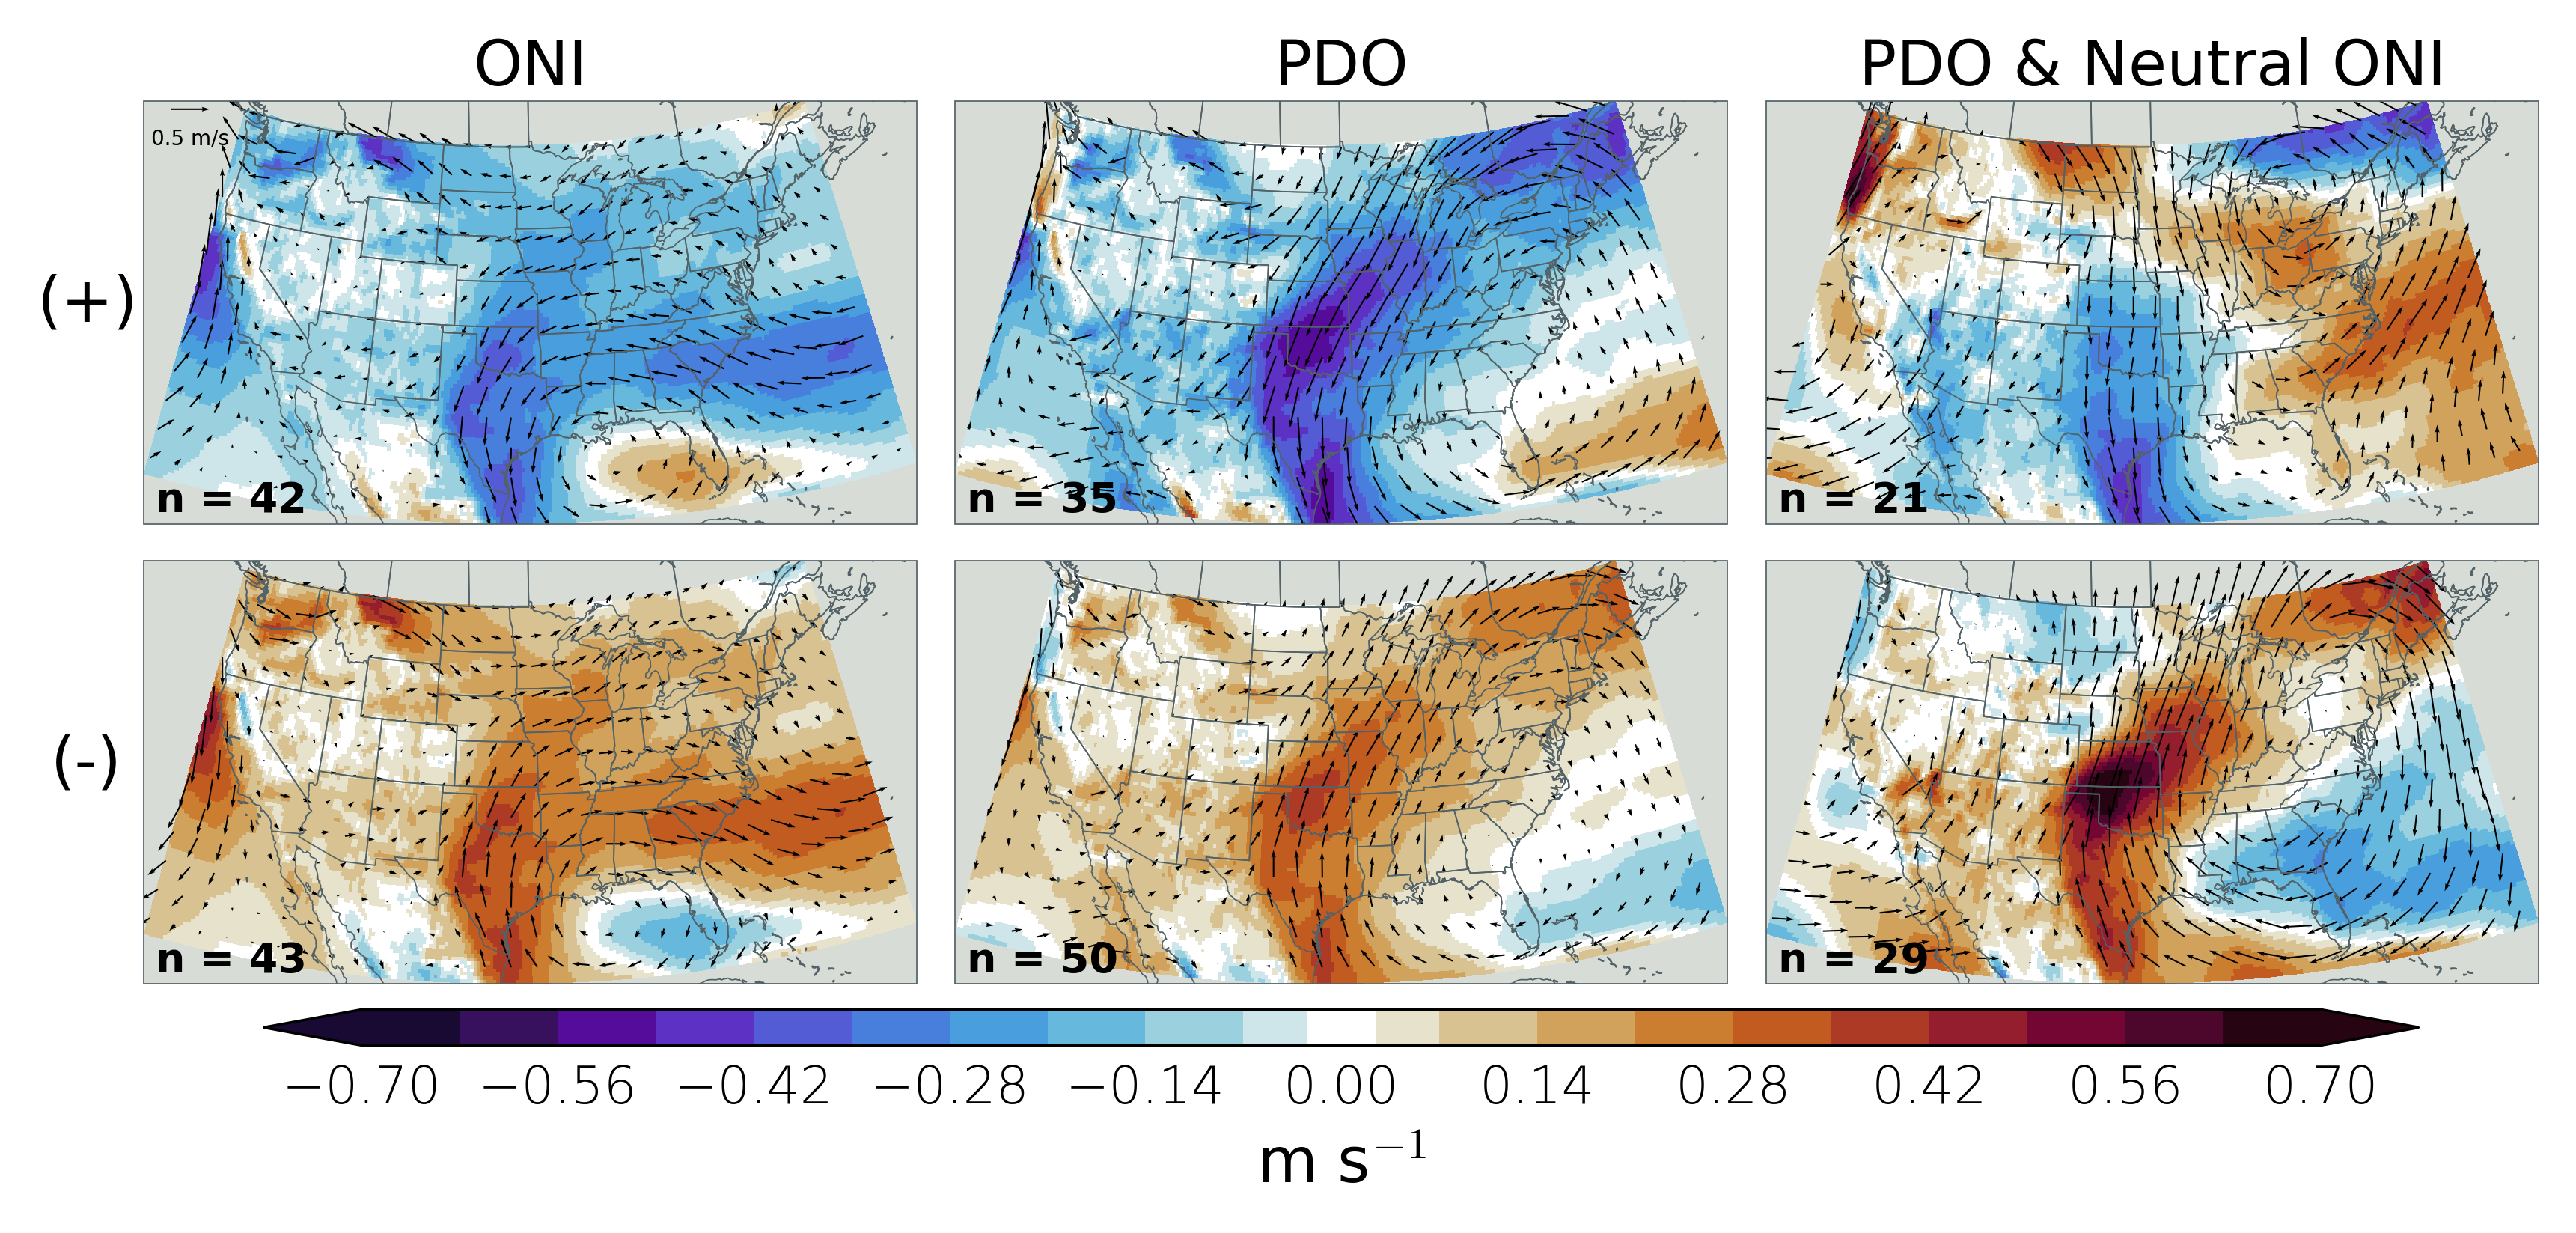

In [231]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

bounds = [-0.7, -0.63, -0.56, -0.49, -0.42, -0.35, -0.28, -0.21, -0.14, -0.07, -0.025, 0.025, 0.07, 0.14, 0.21, 0.28, 0.35, 0.42, 0.49, 0.56, 0.63, 0.7]

norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')
    
ax[0].pcolormesh(u_850['longitude'], u_850['latitude'], ws_850_pos_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)
ax[3].pcolormesh(u_850['longitude'], u_850['latitude'], ws_850_neg_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

ax[1].pcolormesh(u_850['longitude'], u_850['latitude'], ws_850_pos_pdo.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)
ax[4].pcolormesh(u_850['longitude'], u_850['latitude'], ws_850_neg_pdo.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

ax[2].pcolormesh(u_850['longitude'], u_850['latitude'], ws_850_pos_pdo_neut_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)
ax[5].pcolormesh(u_850['longitude'], u_850['latitude'], ws_850_neg_pdo_neut_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

q = ax[0].quiver(u_850['longitude'][::8], u_850['latitude'][::8], u_850_pos_nino.mean(dim='time').values[::8, ::8], v_850_pos_nino.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())
ax[1].quiver(u_850['longitude'][::8], u_850['latitude'][::8], u_850_pos_pdo.mean(dim='time').values[::8, ::8], v_850_pos_pdo.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())
ax[2].quiver(u_850['longitude'][::8], u_850['latitude'][::8], u_850_pos_pdo_neut_nino.mean(dim='time').values[::8, ::8], v_850_pos_pdo_neut_nino.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())

ax[3].quiver(u_850['longitude'][::8], u_850['latitude'][::8], u_850_neg_nino.mean(dim='time').values[::8, ::8], v_850_neg_nino.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())
ax[4].quiver(u_850['longitude'][::8], u_850['latitude'][::8], u_850_neg_pdo.mean(dim='time').values[::8, ::8], v_850_neg_pdo.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())
ax[5].quiver(u_850['longitude'][::8], u_850['latitude'][::8], u_850_neg_pdo_neut_nino.mean(dim='time').values[::8, ::8], v_850_neg_pdo_neut_nino.mean(dim='time').values[::8, ::8], width=0.002, scale=10, transform=ccrs.PlateCarree())

ax[0].quiverkey(q, X=0.06, Y=0.98, U=0.5, label='0.5 m/s', fontproperties={'weight':'normal', 'size':4}, labelpos='S',labelsep=0.05, zorder=100)

ax[0].set_title('ONI', pad=3, fontsize=12)
ax[1].set_title('PDO', pad=3, fontsize=12)
ax[2].set_title('PDO & Neutral ONI', pad=3, fontsize=12)

ax[0].text(-3600000, 100000, '(+)', fontweight='normal', fontsize=12)
ax[3].text(-3500000, 100000, '(-)', fontweight='normal', fontsize=12)

ax[0].text(-2700000, -1350000, f'n = {len(ws_850_pos_nino)}', fontweight='bold', fontsize=8)
ax[3].text(-2700000, -1350000, f'n = {len(ws_850_neg_nino)}', fontweight='bold', fontsize=8)
ax[1].text(-2700000, -1350000, f'n = {len(ws_850_pos_pdo)}', fontweight='bold', fontsize=8)
ax[4].text(-2700000, -1350000, f'n = {len(ws_850_neg_pdo)}', fontweight='bold', fontsize=8)
ax[2].text(-2700000, -1350000, f'n = {len(ws_850_pos_pdo_neut_nino)}', fontweight='bold', fontsize=8)
ax[5].text(-2700000, -1350000, f'n = {len(ws_850_neg_pdo_neut_nino)}', fontweight='bold', fontsize=8)

cax = plt.axes([0.05, .22, 0.9, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-0.7, -0.56, -0.42, -0.28, -0.14, 0, 0.14, 0.28, 0.42, 0.56, 0.7])
cbar.set_label(r'm s$^{-1}$', size=12, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

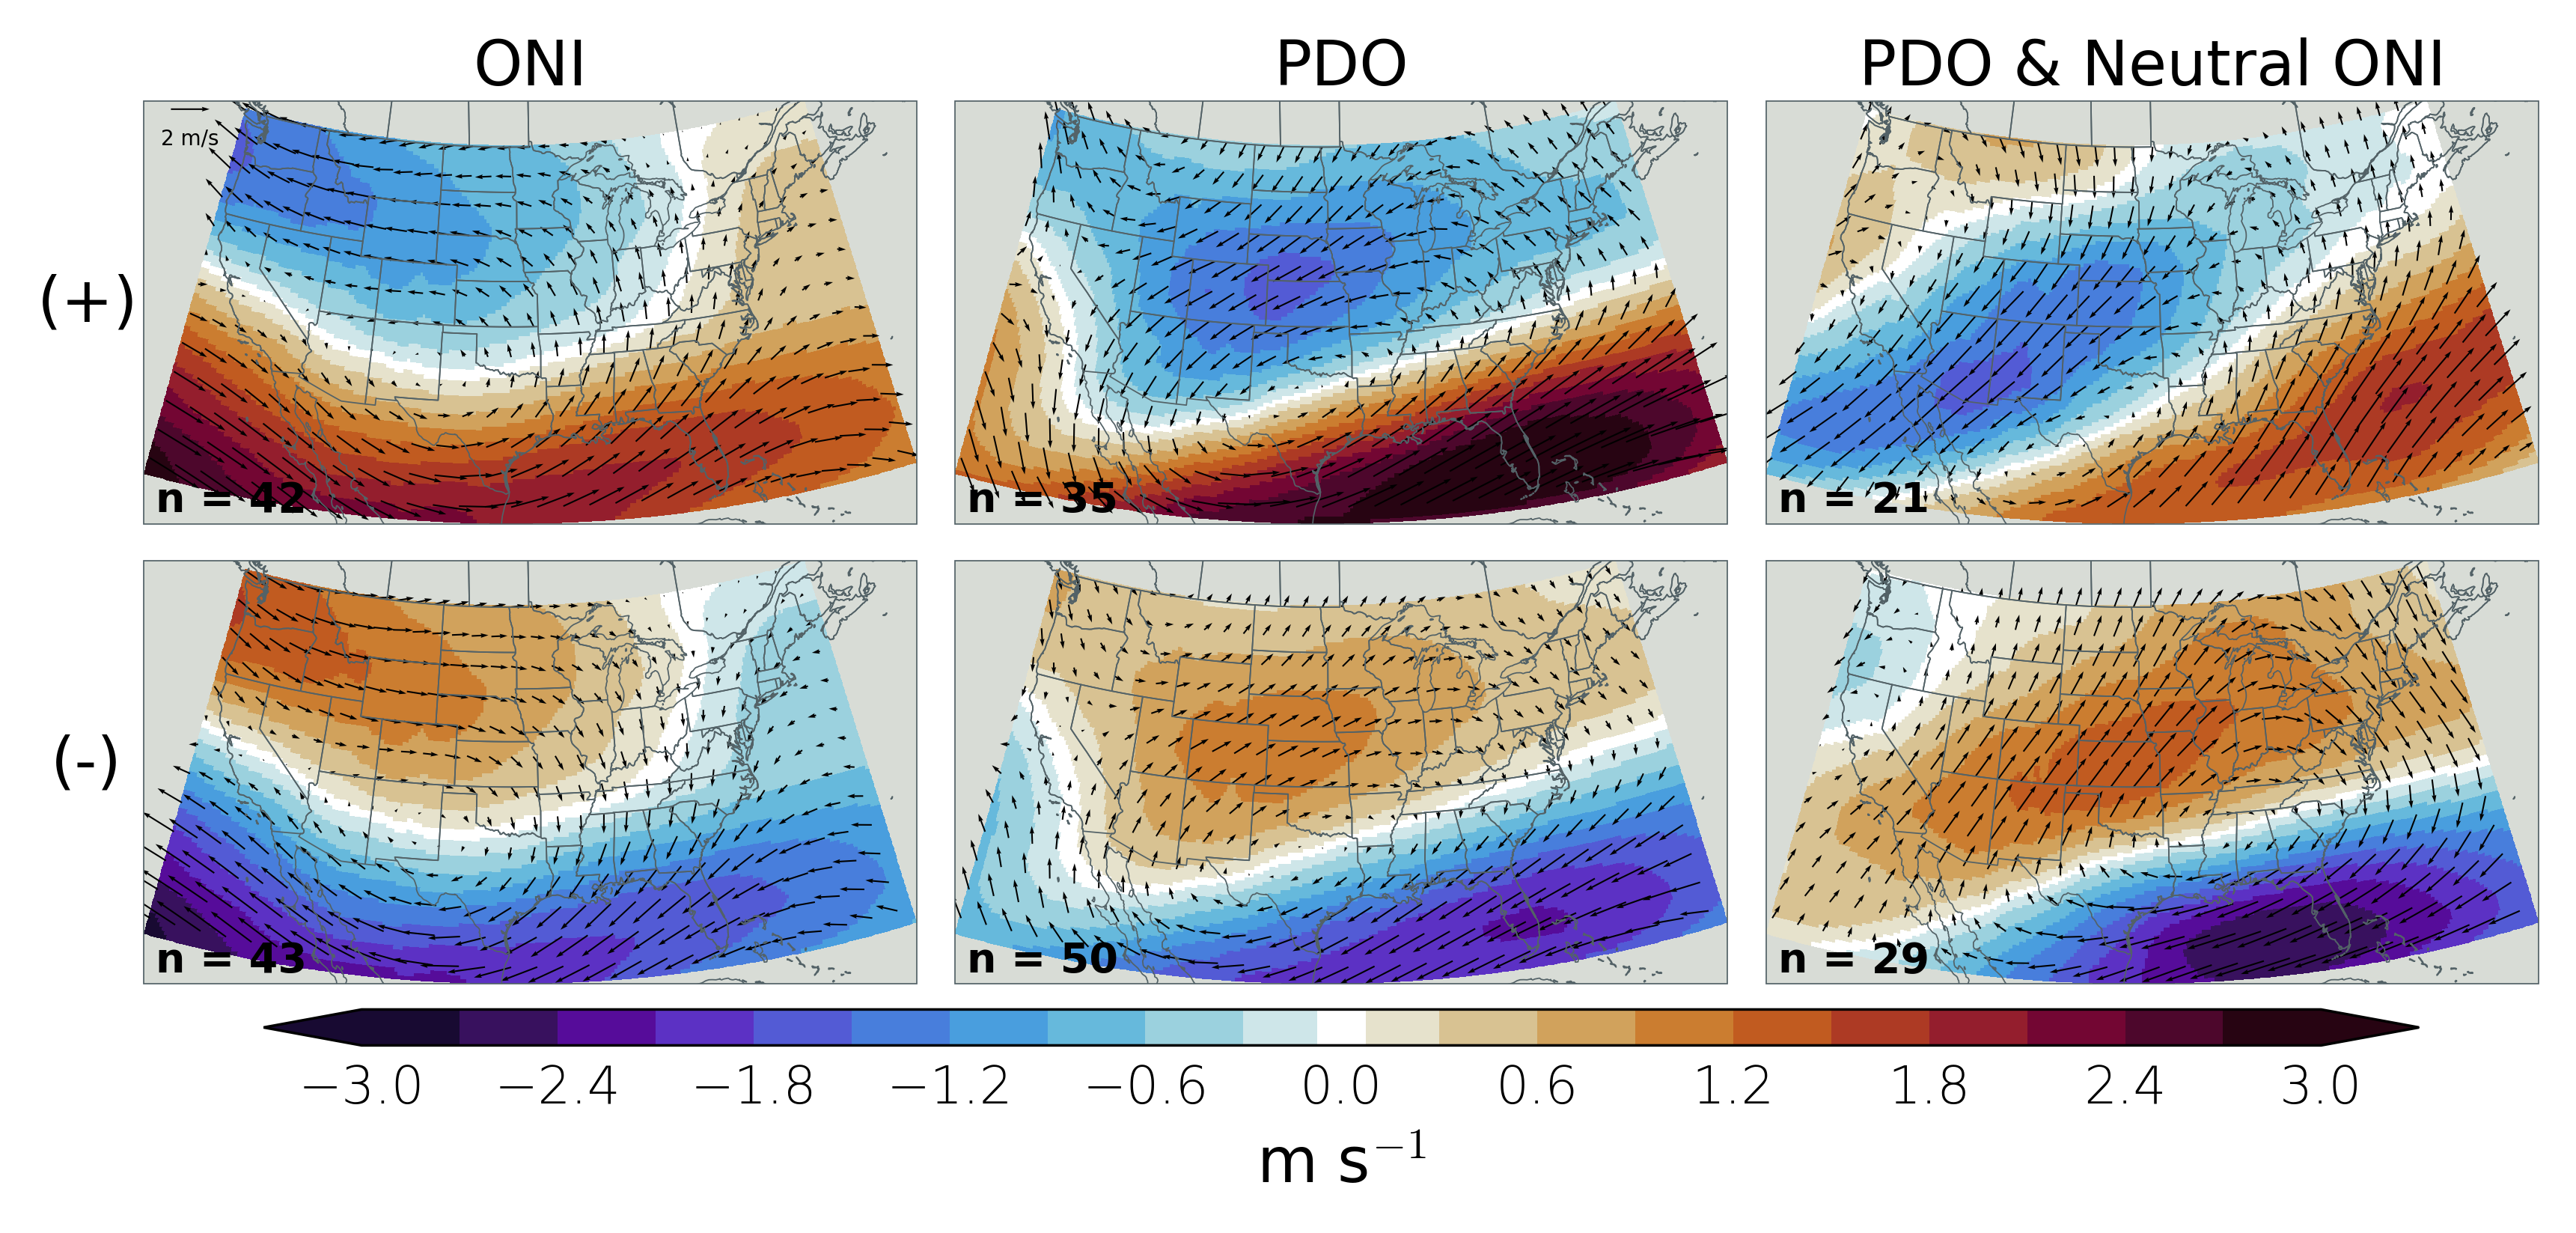

In [229]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

bounds = [-3, -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3, -0.075, 0.075, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3]

norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')
    
ax[0].pcolormesh(u_850['longitude'], u_850['latitude'], ws_200_pos_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)
ax[3].pcolormesh(u_850['longitude'], u_850['latitude'], ws_200_neg_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

ax[1].pcolormesh(u_850['longitude'], u_850['latitude'], ws_200_pos_pdo.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)
ax[4].pcolormesh(u_850['longitude'], u_850['latitude'], ws_200_neg_pdo.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

ax[2].pcolormesh(u_850['longitude'], u_850['latitude'], ws_200_pos_pdo_neut_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)
ax[5].pcolormesh(u_850['longitude'], u_850['latitude'], ws_200_neg_pdo_neut_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

q = ax[0].quiver(u_850['longitude'][::8], u_850['latitude'][::8], u_200_pos_nino.mean(dim='time').values[::8, ::8], v_200_pos_nino.mean(dim='time').values[::8, ::8], width=0.002, scale=40, transform=ccrs.PlateCarree())
ax[1].quiver(u_850['longitude'][::8], u_850['latitude'][::8], u_200_pos_pdo.mean(dim='time').values[::8, ::8], v_200_pos_pdo.mean(dim='time').values[::8, ::8], width=0.002, scale=40, transform=ccrs.PlateCarree())
ax[2].quiver(u_850['longitude'][::8], u_850['latitude'][::8], u_200_pos_pdo_neut_nino.mean(dim='time').values[::8, ::8], v_200_pos_pdo_neut_nino.mean(dim='time').values[::8, ::8], width=0.002, scale=40, transform=ccrs.PlateCarree())

ax[3].quiver(u_850['longitude'][::8], u_850['latitude'][::8], u_200_neg_nino.mean(dim='time').values[::8, ::8], v_200_neg_nino.mean(dim='time').values[::8, ::8], width=0.002, scale=40, transform=ccrs.PlateCarree())
ax[4].quiver(u_850['longitude'][::8], u_850['latitude'][::8], u_200_neg_pdo.mean(dim='time').values[::8, ::8], v_200_neg_pdo.mean(dim='time').values[::8, ::8], width=0.002, scale=40, transform=ccrs.PlateCarree())
ax[5].quiver(u_850['longitude'][::8], u_850['latitude'][::8], u_200_neg_pdo_neut_nino.mean(dim='time').values[::8, ::8], v_200_neg_pdo_neut_nino.mean(dim='time').values[::8, ::8], width=0.002, scale=40, transform=ccrs.PlateCarree())

ax[0].quiverkey(q, X=0.06, Y=0.98, U=2, label='2 m/s', fontproperties={'weight':'normal', 'size':4}, labelpos='S',labelsep=0.05, zorder=100)

ax[0].set_title('ONI', pad=3, fontsize=12)
ax[1].set_title('PDO', pad=3, fontsize=12)
ax[2].set_title('PDO & Neutral ONI', pad=3, fontsize=12)

ax[0].text(-3600000, 100000, '(+)', fontweight='normal', fontsize=12)
ax[3].text(-3500000, 100000, '(-)', fontweight='normal', fontsize=12)

ax[0].text(-2700000, -1350000, f'n = {len(ws_200_pos_nino)}', fontweight='bold', fontsize=8)
ax[3].text(-2700000, -1350000, f'n = {len(ws_200_neg_nino)}', fontweight='bold', fontsize=8)
ax[1].text(-2700000, -1350000, f'n = {len(ws_200_pos_pdo)}', fontweight='bold', fontsize=8)
ax[4].text(-2700000, -1350000, f'n = {len(ws_200_neg_pdo)}', fontweight='bold', fontsize=8)
ax[2].text(-2700000, -1350000, f'n = {len(ws_200_pos_pdo_neut_nino)}', fontweight='bold', fontsize=8)
ax[5].text(-2700000, -1350000, f'n = {len(ws_200_neg_pdo_neut_nino)}', fontweight='bold', fontsize=8)

cax = plt.axes([0.05, .22, 0.9, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-3, -2.4, -1.8, -1.2, -0.6, 0, 0.6, 1.2, 1.8, 2.4, 3])
cbar.set_label(r'm s$^{-1}$', size=12, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

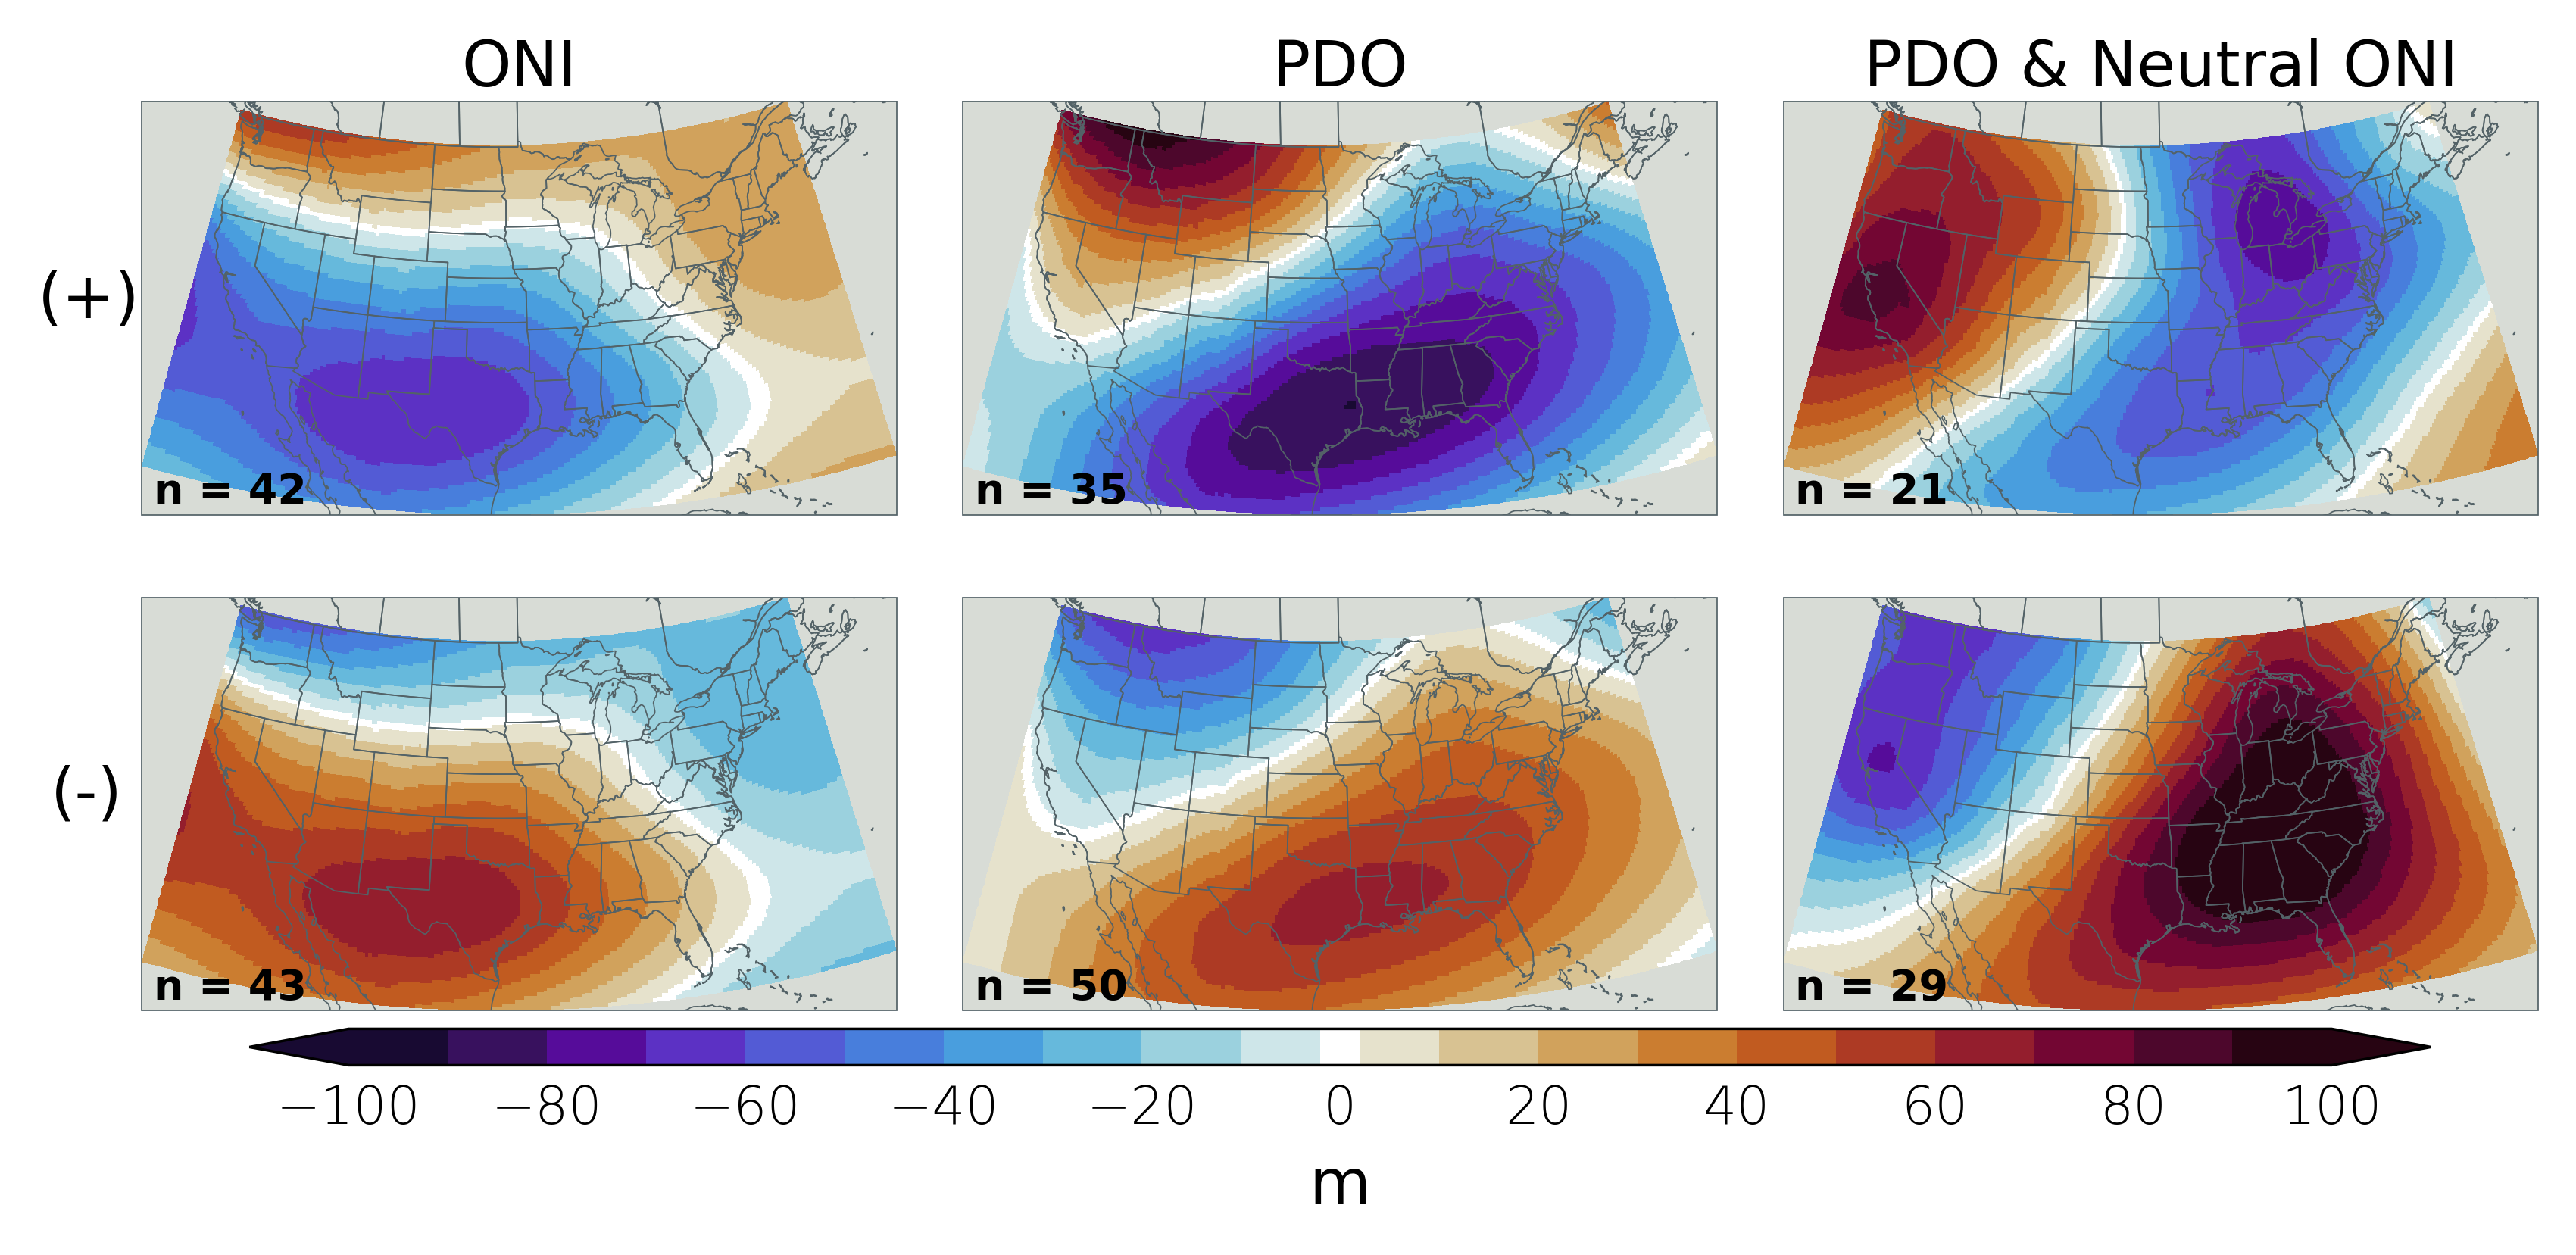

In [230]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

bounds = [-100, -90, -80, -70, -60, -50, -40, -30, -20, -10, -2, 2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')
    
ax[0].pcolormesh(u_850['longitude'], u_850['latitude'], Z_500_pos_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)
ax[3].pcolormesh(u_850['longitude'], u_850['latitude'], Z_500_neg_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

ax[1].pcolormesh(u_850['longitude'], u_850['latitude'], Z_500_pos_pdo.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)
ax[4].pcolormesh(u_850['longitude'], u_850['latitude'], Z_500_neg_pdo.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

ax[2].pcolormesh(u_850['longitude'], u_850['latitude'], Z_500_pos_pdo_neut_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)
ax[5].pcolormesh(u_850['longitude'], u_850['latitude'], Z_500_neg_pdo_neut_nino.mean(dim='time'), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

ax[0].set_title('ONI', pad=3, fontsize=8)
ax[1].set_title('PDO', pad=3, fontsize=8)
ax[2].set_title('PDO & Neutral ONI', pad=3, fontsize=8)

ax[0].set_title('ONI', pad=3, fontsize=12)
ax[1].set_title('PDO', pad=3, fontsize=12)
ax[2].set_title('PDO & Neutral ONI', pad=3, fontsize=12)

ax[0].text(-3600000, 100000, '(+)', fontweight='normal', fontsize=12)
ax[3].text(-3500000, 100000, '(-)', fontweight='normal', fontsize=12)

ax[0].text(-2700000, -1350000, f'n = {len(Z_500_pos_nino)}', fontweight='bold', fontsize=8)
ax[3].text(-2700000, -1350000, f'n = {len(Z_500_neg_nino)}', fontweight='bold', fontsize=8)
ax[1].text(-2700000, -1350000, f'n = {len(Z_500_pos_pdo)}', fontweight='bold', fontsize=8)
ax[4].text(-2700000, -1350000, f'n = {len(Z_500_neg_pdo)}', fontweight='bold', fontsize=8)
ax[2].text(-2700000, -1350000, f'n = {len(Z_500_pos_pdo_neut_nino)}', fontweight='bold', fontsize=8)
ax[5].text(-2700000, -1350000, f'n = {len(Z_500_neg_pdo_neut_nino)}', fontweight='bold', fontsize=8)

cax = plt.axes([0.05, .22, 0.9, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100])
cbar.set_label(r'm', size=12, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.2)